In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pydotplus

### Data load & preprocessing 

In [2]:
from dataset.mnist import load_mnist

(train_raw_img, train_y), (test_raw_img, test_y) = load_mnist(flatten=False, normalize=False)

# reshape 
train_X = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
test_X = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [3]:
# preprocessing : normalization(set 0~1)
train_X = train_X.astype('float')/255
test_X = test_X.astype('float')/255

### Model

In [4]:
def information_gain(y, y_left, y_right):
    def entropy(y):
        class_labels = np.unique(y)
        entropy = 0
        for label in class_labels:
            p = np.sum(y == label) / len(y)
            entropy += -p * np.log2(p)
        return entropy

    entropy_before = entropy(y)
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    
    entropy_after = (len(y_left) / len(y)) * entropy_left + (len(y_right) / len(y)) * entropy_right
    return entropy_before - entropy_after

In [5]:
def make_tree(X, y, max_depth, depth=0) :
    if depth == max_depth or len(np.unique(y)) == 1 : # stopping conditions
        return {'class' : np.argmax(np.bincount(y))} # return class
    
    best_feature, best_threshold = find_best_split(X, y)
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = X[:, best_feature] > best_threshold
    left_node = make_tree(X[left_mask], y[left_mask], max_depth, depth + 1, )
    right_node = make_tree(X[right_mask], y[right_mask], max_depth, depth + 1)
    
    return {'feature': best_feature, 'threshold': best_threshold, 'left': left_node, 'right': right_node}

def find_best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None

    for feature_idx in range(X.shape[1]):
        feature_values = X[:, feature_idx]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            y_left = y[feature_values <= threshold]
            y_right = y[feature_values > threshold]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            gain = information_gain(y, y_left, y_right)

            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

def prediction(x, node) :
    if 'class' in node :
        return node['class']
    feature = node['feature']
    feature = node['feature']
    threshold = node['threshold']

    if x[feature] <= threshold:
        return prediction(x, node['left'])
    else:
        return prediction(x, node['right'])

### train & evaluation

In [33]:
# early stopping
model = make_tree(train_X, train_y, max_depth=0)
model

{'class': 1}

In [34]:
pred1 = np.array([prediction(x, model) for x in train_X])
pred2 = np.array([prediction(x, model) for x in test_X])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.11236666666666667
early stopping in test set : 0.1135


#### 1) math depth = 1

In [36]:
model1 = make_tree(train_X, train_y, max_depth=1)
model1

{'feature': 461, 'threshold': 0.0, 'left': {'class': 0}, 'right': {'class': 1}}

In [37]:
pred1 = np.array([prediction(x, model1) for x in train_X])
pred2 = np.array([prediction(x, model1) for x in test_X])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.20411666666666667
early stopping in test set : 0.206


#### 2) math depth = 2

In [38]:
model2 = make_tree(train_X, train_y, max_depth=2)
model2

{'feature': 461,
 'threshold': 0.0,
 'left': {'feature': 378,
  'threshold': 0.011764705882352941,
  'left': {'class': 0},
  'right': {'class': 3}},
 'right': {'feature': 401,
  'threshold': 0.0,
  'left': {'class': 1},
  'right': {'class': 4}}}

In [39]:
pred1 = np.array([prediction(x, model2) for x in train_X])
pred2 = np.array([prediction(x, model2) for x in test_X])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.33665
early stopping in test set : 0.3398


#### 3) math depth = 3

In [40]:
model3 = make_tree(train_X, train_y, max_depth=3)
model3

{'feature': 461,
 'threshold': 0.0,
 'left': {'feature': 378,
  'threshold': 0.011764705882352941,
  'left': {'feature': 597,
   'threshold': 0.0,
   'left': {'class': 7},
   'right': {'class': 0}},
  'right': {'feature': 625,
   'threshold': 0.00392156862745098,
   'left': {'class': 9},
   'right': {'class': 3}}},
 'right': {'feature': 401,
  'threshold': 0.0,
  'left': {'feature': 378,
   'threshold': 0.5686274509803921,
   'left': {'class': 2},
   'right': {'class': 1}},
  'right': {'feature': 542,
   'threshold': 0.043137254901960784,
   'left': {'class': 4},
   'right': {'class': 6}}}}

In [41]:
pred1 = np.array([prediction(x, model3) for x in train_X])
pred2 = np.array([prediction(x, model3) for x in test_X])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.4881333333333333
early stopping in test set : 0.4918


#### 4) math depth = 5

In [42]:
model5 = make_tree(train_X, train_y, max_depth=5)
model5

{'feature': 461,
 'threshold': 0.0,
 'left': {'feature': 378,
  'threshold': 0.011764705882352941,
  'left': {'feature': 597,
   'threshold': 0.0,
   'left': {'feature': 514,
    'threshold': 0.0196078431372549,
    'left': {'feature': 623,
     'threshold': 0.0,
     'left': {'class': 7},
     'right': {'class': 0}},
    'right': {'feature': 241,
     'threshold': 0.01568627450980392,
     'left': {'class': 6},
     'right': {'class': 0}}},
   'right': {'feature': 428,
    'threshold': 0.0,
    'left': {'feature': 490,
     'threshold': 0.06274509803921569,
     'left': {'class': 0},
     'right': {'class': 2}},
    'right': {'feature': 243,
     'threshold': 0.0,
     'left': {'class': 0},
     'right': {'class': 0}}}},
  'right': {'feature': 625,
   'threshold': 0.00392156862745098,
   'left': {'feature': 542,
    'threshold': 0.00392156862745098,
    'left': {'feature': 325,
     'threshold': 0.043137254901960784,
     'left': {'class': 5},
     'right': {'class': 9}},
    'right':

In [43]:
pred1 = np.array([prediction(x, model5) for x in train_X])
pred2 = np.array([prediction(x, model5) for x in test_X])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.6933333333333334
early stopping in test set : 0.6995


## 심화 문제

In [77]:
import networkx as nx

In [52]:
from dataset.mnist import load_mnist

(train_raw_img, train_y), (test_raw_img, test_y) = load_mnist(flatten=False, normalize=False)

In [53]:
# reshape 
train_X = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
test_X = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)

# nomaization 1 (set value 0 ~ 1)
train_X = train_X.astype('float')/255
test_X = test_X.astype('float')/255

In [62]:
def power_iteration(X, num_iter=100, epsilon=1e-10):
    n, d = X.shape
    b_k = np.random.rand(d)
    
    for _ in range(num_iter):
        # 주어진 행렬과 곱하기
        b_k1 = np.dot(X, b_k)
        
        # 정규화
        b_k1_norm = np.linalg.norm(b_k1)
        
        # 다음 단계를 위해 업데이트
        b_k_next = b_k1 / b_k1_norm
        
        # 수렴 확인
        if np.linalg.norm(b_k_next[:d] - b_k) < epsilon:
            return b_k_next[:d]
        
        b_k = b_k_next[:d]
        
    return b_k

In [63]:
def pca(X, n_components):
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    components = np.zeros((n_components, cov_matrix.shape[1]))

    for i in range(n_components):
        component = power_iteration(cov_matrix)
        components[i, :] = component
        cov_matrix -= np.outer(component, component) * np.dot(component.T, cov_matrix)

    return np.dot(X_centered, components.T)

In [78]:
# PCA
train_X_2D = pca(train_X, 2)
test_X_2D = pca(test_X, 2)

# Build decision tree
model = make_tree(train_X_2D, train_y, max_depth=1)

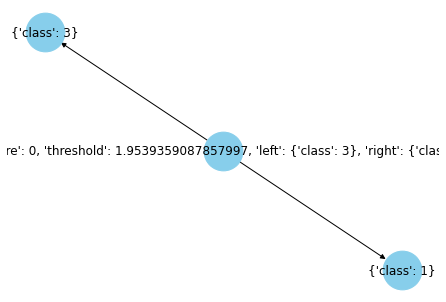

In [79]:
def draw(node, parent=None, graph=None):
    if graph is None:
        graph = nx.DiGraph()
    if parent is not None:
        graph.add_edge(parent, str(node))
    if 'class' in node:
        return graph
    else:
        draw(node['left'], str(node), graph)
        draw(node['right'], str(node), graph)
        return graph

def visualize_tree_networkx(node):
    graph = draw(node)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='skyblue')
    plt.show()

visualize_tree_networkx(model)

In [87]:
pred1 = np.array([prediction(x, model) for x in train_X_2D])
pred2 = np.array([prediction(x, model) for x in test_X_2D])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.20183333333333334
early stopping in test set : 0.0971


#### 1) math depth = 0

In [89]:
# PCA
train_X_2D = pca(train_X, 2)
test_X_2D = pca(test_X, 2)

# Build decision tree
model = make_tree(train_X_2D, train_y, max_depth=0)

In [90]:
pred1 = np.array([prediction(x, model) for x in train_X_2D])
pred2 = np.array([prediction(x, model) for x in test_X_2D])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.11236666666666667
early stopping in test set : 0.1135


#### 2) math depth = 2

In [93]:
# PCA
train_X_2D = pca(train_X, 2)
test_X_2D = pca(test_X, 2)

# Build decision tree
model = make_tree(train_X_2D, train_y, max_depth=2)

In [94]:
pred1 = np.array([prediction(x, model) for x in train_X_2D])
pred2 = np.array([prediction(x, model) for x in test_X_2D])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.27958333333333335
early stopping in test set : 0.2817


#### 4) math depth = 4

In [95]:
# PCA
train_X_2D = pca(train_X, 2)
test_X_2D = pca(test_X, 2)

# Build decision tree
model = make_tree(train_X_2D, train_y, max_depth=4)

In [96]:
pred1 = np.array([prediction(x, model) for x in train_X_2D])
pred2 = np.array([prediction(x, model) for x in test_X_2D])

print('early stopping in train set :', np.mean(pred1==train_y))
print('early stopping in test set :', np.mean(pred2==test_y))

early stopping in train set : 0.3028666666666667
early stopping in test set : 0.3101
